# **Setup**

## 1.1 Install Packages

In [1]:
!pip install imbalanced-learn
!pip install -q transformers
!pip install black[jupyter]
!pip install "ray[tune]"

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 43.0 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 52.6 MB/s 
     |████████████████████████████████| 895 kB 60.0 MB/s 
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 96 kB 5.6 MB/s 
     |████████████████████████████████| 843 kB 50.0 MB/s 
     |████████████████████████████████| 793 kB 48.0 MB/s 
     |████████████████████████████████| 381 kB 46.1 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstal

     |████████████████████████████████| 53.2 MB 104 kB/s 
     |████████████████████████████████| 8.8 MB 58.7 MB/s 
     |████████████████████████████████| 144 kB 68.5 MB/s 
     |████████████████████████████████| 4.1 MB 58.0 MB/s 
     |████████████████████████████████| 125 kB 58.2 MB/s 
     |████████████████████████████████| 461 kB 68.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


## 1.2 Import Libraries

In [2]:
# indonlu repository forked from https://github.com/indobenchmark/indonlu
!git clone https://github.com/ryzanugrah/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 475 (delta 45), reused 32 (delta 15), pack-reused 394
Receiving objects: 100% (475/475), 4.84 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (240/240), done.


In [3]:
import os
import pickle
import random

from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from google.colab import data_table, drive
from indonlu.utils.data_utils import (
    HateSpeechClassificationDataLoader,
    MultiLabelHateSpeechClassificationDataset,
)
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import multi_label_hate_speech_classification_metrics_fn
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from torch import optim
from tqdm import tqdm
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer

## 1.3 Colab Configuration
You can ignore this section if you are not using Google Colab

In [4]:
# mount Drive
# drive.mount("/content/drive")

# enable data table display (interactive table)
data_table.enable_dataframe_formatter()

## 1.4 Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 GPU`

Then run the following cell to confirm that the GPU is detected.

In [5]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: Tesla T4


## 1.4 Set Random Seed

In [7]:
# common functions
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
    
# count number of parameters  
def count_param(module, trainable=False):
  if trainable:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in module.parameters())

# get the learning rate
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

# change from metrics evaluation to string
def metrics_to_string(metric_dict):
  string_list = []
  
  for key, value in metric_dict.items():
    string_list.append('{}:{:.2f}'.format(key, value))
  return ' '.join(string_list)

# set random seed
set_seed(0)
random_state=0

In [8]:
# """
# This example is uses the official
# huggingface transformers `hyperparameter_search` API.
# """
# import os

# import psutil
# import ray
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.examples.pbt_transformers.utils import (
#     download_data,
#     build_compute_metrics_fn,
# )
# from ray.tune.schedulers import PopulationBasedTraining
# from transformers import (
#     glue_tasks_num_labels,
#     AutoConfig,
#     BertForSequenceClassification,
#     AutoTokenizer,
#     Trainer,
#     GlueDataset,
#     GlueDataTrainingArguments,
#     TrainingArguments,
# )


# def tune_transformer(num_samples=8, gpus_per_trial=0, smoke_test=False):
#     data_dir_name = "./data" if not smoke_test else "./test_data"
#     data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
#     if not os.path.exists(data_dir):
#         os.mkdir(data_dir, 0o755)

#     # Change these as needed.
#     model_name = (
#         "indobert-base-p1" if not smoke_test else "indobenchmark/indobert-base-p1"
#     )
#     task_name = "rte"

#     task_data_dir = os.path.join(data_dir, task_name.upper())

#     num_labels = glue_tasks_num_labels[task_name]

#     config = BertConfig.from_pretrained(model_name, num_labels=num_labels, finetuning_task=task_name)

#     # Download and cache tokenizer, model, and features
#     print("Downloading and caching Tokenizer")
#     tokenizer = BertTokenizer.from_pretrained(model_name)

#     # Triggers tokenizer download to cache
#     print("Downloading and caching pre-trained model")
#     BertForSequenceClassification.from_pretrained(
#         model_name,
#         config=config,
#     )

#     def get_model():
#         return BertForSequenceClassification.from_pretrained(
#             model_name,
#             config=config,
#         )

#     # Download data.
#     # download_data(task_name, data_dir)

#     train_dataset_path = 'dataset_training.csv'
#     test_dataset_path = 'dataset_testing.csv'
#     eval_dataset_path = 'dataset_validation.csv'

#     train_dataset = MultiLabelHateSpeechClassificationDataset(train_dataset_path, tokenizer, lowercase=True)
#     testing_dataset = MultiLabelHateSpeechClassificationDataset(test_dataset_path, tokenizer, lowercase=True)
#     eval_dataset = MultiLabelHateSpeechClassificationDataset(eval_dataset_path, tokenizer, lowercase=True)

#     training_args = TrainingArguments(
#         output_dir=".",
#         learning_rate=1e-5,  # config
#         do_train=True,
#         do_eval=True,
        
#         no_cuda=gpus_per_trial <= 0,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         num_train_epochs=2,  # config
#         max_steps=-1,
#         per_device_train_batch_size=16,  # config
#         per_device_eval_batch_size=16,  # config
#         warmup_steps=0,
#         weight_decay=0.1,  # config
#         logging_dir="logs",
#         skip_memory_metrics=True,
#         report_to="none",
#     )

#     trainer = Trainer(
#         model_init=get_model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=eval_dataset,
#         compute_metrics=build_compute_metrics_fn(task_name),
#     )

#     tune_config = {
#         "per_device_train_batch_size": 32,
#         "per_device_eval_batch_size": 32,
#         "num_train_epochs": tune.choice([2, 3, 4]),
#         "num_workers" : 1,
#         "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
#     }

#     scheduler = PopulationBasedTraining(
#         time_attr="training_iteration",
#         metric="eval_acc",
#         mode="max",
#         perturbation_interval=1,
#         hyperparam_mutations={
#             "weight_decay": tune.uniform(0.0, 0.3),
#             "learning_rate": tune.uniform(1e-5, 5e-5),
#             "per_device_train_batch_size": [16, 32],
#         },
#     )

#     reporter = CLIReporter(
#         parameter_columns={
#             "weight_decay": "w_decay",
#             "learning_rate": "lr",
#             "per_device_train_batch_size": "train_bs/gpu",
#             "num_train_epochs": "num_epochs",
#         },
#         metric_columns=["eval_acc", "eval_loss", "epoch", "training_iteration"],
#     )

#     trainer.hyperparameter_search(
#         hp_space=lambda _: tune_config,
#         backend="ray",
#         n_trials=num_samples,
#         resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
#         scheduler=scheduler,
#         keep_checkpoints_num=1,
#         checkpoint_score_attr="training_iteration",
#         stop={"training_iteration": 1} if smoke_test else None,
#         progress_reporter=reporter,
#         local_dir="ray_results/",
#         name="tune_transformer_pbt",
#         log_to_file=True,
#     )


# if __name__ == "__main__":
#     import argparse

#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--smoke-test", default=True, action="store_true", help="Finish quickly for testing"
#     )
#     parser.add_argument(
#         "--ray-address",
#         type=str,
#         default=None,
#         help="Address to use for Ray. "
#              'Use "auto" for cluster. '
#              "Defaults to None for local.",
#     )
#     parser.add_argument(
#         "--server-address",
#         type=str,
#         default=None,
#         required=False,
#         help="The address of server to connect to if using " "Ray Client.",
#     )

#     args, _ = parser.parse_known_args()

#     if args.smoke_test:
#         # ray.init()
#         ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
#     elif args.server_address:
#         ray.init(f"ray://{args.server_address}")
#     else:
#         ray.init(args.ray_address)

#     if args.smoke_test:
#         tune_transformer(num_samples=1, gpus_per_trial=1, smoke_test=True)
#     else:
#         # You can change the number of GPUs here:
#         tune_transformer(num_samples=8, gpus_per_trial=1)

In [9]:
# from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
#                           Trainer, TrainingArguments)

# tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# train_dataset_path = 'dataset_training.csv'
# test_dataset_path = 'dataset_testing.csv'
# eval_dataset_path = 'dataset_validation.csv'

# train_dataset = MultiLabelHateSpeechClassificationDataset(train_dataset_path, tokenizer, lowercase=True)
# testing_dataset = MultiLabelHateSpeechClassificationDataset(test_dataset_path, tokenizer, lowercase=True)
# eval_dataset = MultiLabelHateSpeechClassificationDataset(eval_dataset_path, tokenizer, lowercase=True)

# config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

# def model_init():
#     return BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# # def compute_metrics(eval_pred):
# #     predictions, labels = eval_pred
# #     predictions = predictions.argmax(axis=-1)
# #     return metric.compute(predictions=predictions, references=labels)

# # Evaluate during training and a bit more often
# # than the default to be able to prune bad trials early.
# # Disabling tqdm is a matter of preference.
# training_args = TrainingArguments(
#     "test", evaluation_strategy="steps", eval_steps=500, disable_tqdm=True)
# trainer = Trainer(
#     args=training_args,
#     tokenizer=tokenizer,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     model_init=model_init,
#     # compute_metrics=compute_metrics,
# )

# # Default objective is the sum of all metrics
# # when metrics are provided, so we have to maximize it.
# trainer.hyperparameter_search(
#     direction="maximize", 
#     backend="ray",
#     resources_per_trial={"cpu": 2, "gpu": 2},
# )

# **Split Up Dataset**

## 2.1 Import Preprocessed Dataset



In [10]:
# import preprocessed dataset
df = pd.read_csv("dataset_preprocessed.csv")

In [11]:
# show the first 5 dataset rows
print("Number of Data: ", df.shape)
df.head()

Number of Data:  (13114, 2)


,text,label
0,cowok usaha lacak perhati gue lantas remeh per...,1
1,telat tau edan sarap gue gaul cigax jifla cal ...,3
2,kadang pikir percaya tuhan jatuh kali kali kad...,0
3,ku tau mata sipit,0
4,kaum cebong kafir dongok dungu haha,2


## 2.2 Hold-out Validation
Split up dataset into train, test, and valid set with a ratio of 80% train, 10% test, and 10% valid

In [12]:
# define dataset
X = df["text"]
y = df["label"]

# split into 80:10:10 ration
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=random_state)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=random_state
)

# describe info about train, test, and valid set
print("Number of Train Dataset: ", y_train.shape)
print(y_train.value_counts())

print("\nNumber of Test Dataset: ", y_test.shape)
print(y_test.value_counts())

print("\nNumber of Valid Dataset: ", y_valid.shape)
print(y_valid.value_counts())

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_valid = pd.concat([X_valid, y_valid], axis=1)

df_train.to_csv("dataset_training.csv", index=False)
df_test.to_csv("dataset_testing.csv", index=False)
df_valid.to_csv("dataset_validation.csv", index=False)

Number of Train Dataset:  (10491,)
0    4673
1    2684
3    1785
2    1349
Name: label, dtype: int64

Number of Test Dataset:  (1312,)
0    577
1    332
3    230
2    173
Name: label, dtype: int64

Number of Valid Dataset:  (1311,)
0    565
1    359
3    205
2    182
Name: label, dtype: int64


In [13]:
df_train = pd.read_csv("dataset_training.csv")
df_test = pd.read_csv("dataset_testing.csv")
df_valid = pd.read_csv("dataset_validation.csv")

## 2.3 Balancing Data with SMOTE (Optional)
Uncomment this section if you want to work with balance data

In [14]:
# # convert strings into numericals using TfidfVectorizer
# vec_train = TfidfVectorizer()
# vec_test = TfidfVectorizer()
# vec_valid = TfidfVectorizer()

# df_train = pd.read_csv('dataset_training.csv')
# X_train = vec_train.fit_transform(df_train['text'])

# df_test = pd.read_csv('dataset_testing.csv')
# X_test = vec_test.fit_transform(df_test['text'])

# df_valid = pd.read_csv('dataset_validation.csv')
# X_valid = vec_valid.fit_transform(df_valid['text'])

In [15]:
# sm = SMOTE(random_state = 42)

# X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
# X_test_res, y_test_res = sm.fit_resample(X_test, y_test.ravel())
# X_valid_res, y_valid_res = sm.fit_resample(X_valid, y_valid.ravel())

# # convert back into strings using inverse_transform
# X_train_res = vec_train.inverse_transform(X_train_res)
# X_test_res = vec_test.inverse_transform(X_test_res)
# X_valid_res = vec_valid.inverse_transform(X_valid_res)

# pd.DataFrame({'text': X_train_res}).to_csv("X_train.csv", index=False)
# pd.DataFrame({'label': y_train_res}).to_csv("y_train.csv", index=False)

# pd.DataFrame({'text': X_test_res}).to_csv("X_test.csv", index=False)
# pd.DataFrame({'label': y_test_res}).to_csv("y_test.csv", index=False)

# pd.DataFrame({'text': X_valid_res}).to_csv("X_valid.csv", index=False)
# pd.DataFrame({'label': y_valid_res}).to_csv("y_valid.csv", index=False)

In [16]:
# print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
# print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
# print("Before OverSampling, counts of label '2': {}".format(sum(y_train == 2)))
# print("Before OverSampling, counts of label '3': {} \n".format(sum(y_train == 3)))

# print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

# print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
# print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
# print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2)))
# print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3)))

In [17]:
# print("Before OverSampling, counts of label '0': {}".format(sum(y_test == 0)))
# print("Before OverSampling, counts of label '1': {}".format(sum(y_test == 1)))
# print("Before OverSampling, counts of label '2': {}".format(sum(y_test == 2)))
# print("Before OverSampling, counts of label '3': {} \n".format(sum(y_test == 3)))

# print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

# print("After OverSampling, counts of label '0': {}".format(sum(y_test_res == 0)))
# print("After OverSampling, counts of label '1': {}".format(sum(y_test_res == 1)))
# print("After OverSampling, counts of label '2': {}".format(sum(y_test_res == 2)))
# print("After OverSampling, counts of label '3': {}".format(sum(y_test_res == 3)))

In [18]:
# print("Before OverSampling, counts of label '0': {}".format(sum(y_valid == 0)))
# print("Before OverSampling, counts of label '1': {}".format(sum(y_valid == 1)))
# print("Before OverSampling, counts of label '2': {}".format(sum(y_valid == 2)))
# print("Before OverSampling, counts of label '3': {} \n".format(sum(y_valid == 3)))

# print('After OverSampling, the shape of valid_y: {} \n'.format(y_valid_res.shape))

# print("After OverSampling, counts of label '0': {}".format(sum(y_valid_res == 0)))
# print("After OverSampling, counts of label '1': {}".format(sum(y_valid_res == 1)))
# print("After OverSampling, counts of label '2': {}".format(sum(y_valid_res == 2)))
# print("After OverSampling, counts of label '3': {}".format(sum(y_valid_res == 3)))

In [19]:
# def data_cleaning(text):
#   text = re.sub("['']", "", text)
#   text = text.replace('[', '').replace(']', '')
#   return text

# df_train = pd.read_csv('X_train.csv')
# df_test = pd.read_csv('X_test.csv')
# df_valid = pd.read_csv('X_valid.csv')

# df_train["text"] = df_train["text"].apply(data_cleaning)
# df_train.text = df_train.text.str.strip()

# df_test["text"] = df_test["text"].apply(data_cleaning)
# df_test.text = df_test.text.str.strip()

# df_valid["text"] = df_valid["text"].apply(data_cleaning)
# df_valid.text = df_valid.text.str.strip()

In [20]:
# df_train[["text"]].head()

In [21]:
# df_test[["text"]].head()

In [22]:
# df_valid[["text"]].head()

In [23]:
# df_train.to_csv("X_train.csv", index=False)
# df_test.to_csv("X_test.csv", index=False)
# df_valid.to_csv("X_valid.csv", index=False)

In [24]:
# # save data training
# df_X_train = pd.read_csv('X_train.csv')
# df_y_train = pd.read_csv('y_train.csv')

# df_train = pd.concat([df_X_train, df_y_train], axis=1)

In [25]:
# # save data testing
# df_X_test = pd.read_csv('X_test.csv')
# df_y_test = pd.read_csv('y_test.csv')

# df_test = pd.concat([df_X_test, df_y_test], axis=1)

In [26]:
# # save data validation
# df_X_valid = pd.read_csv('X_valid.csv')
# df_y_valid = pd.read_csv('y_valid.csv')

# df_valid = pd.concat([df_X_valid, df_y_valid], axis=1)

## 2.4 Label Classification

In [27]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_train["label"] = df_train["label"].apply(label_classification)

df_train = df_train[["text", "label"]]

df_train.to_csv("dataset_training.csv", index=False)

df_train.head()

,text,label
0,iya mas inflasi pakai maki tolol dongok super,HS_Weak
1,bubar dewan wakil rakyat bubar save komisi ber...,HS_Strong
2,thailand tuntut ilmu tinggal gereja kristen ba...,Non_HS
3,bubar hati amp front bela islam,HS_Strong
4,aku orang pintar agama memang agama boleh nist...,HS_Strong


In [28]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_test["label"] = df_test["label"].apply(label_classification)

df_test = df_test[["text", "label"]]

df_test.to_csv("dataset_testing.csv", index=False)

df_test.head()

,text,label
0,adik tengok keliling adik nak cam agama first ...,Non_HS
1,malas duduk xleh orang kg budaya kg duduk xleh...,Non_HS
2,res res cebong goblok ya res maklum,HS_Moderate
3,tahu gue sih indonesia barat gue orang aku ate...,Non_HS
4,sadar bahasa kampret cebong sekian tebar bahas...,HS_Moderate


In [29]:
def label_classification(hs):
    label = ""

    if int(hs) == 1:
        label = "HS_Weak"
    elif int(hs) == 2:
        label = "HS_Moderate"
    elif int(hs) == 3:
        label = "HS_Strong"
    else:
        label = "Non_HS"

    return label


df_valid["label"] = df_valid["label"].apply(label_classification)

df_valid = df_valid[["text", "label"]]

df_valid.to_csv("dataset_validation.csv", index=False)

df_valid.head()

,text,label
0,gogobli mudah toko obat apotek pasok obat online,Non_HS
1,orang orang tawar rumah sih yahudi jual tingga...,Non_HS
2,shua saudara jauh kunti oppa,Non_HS
3,aneh konsultan asing pakai mulus korupsi jabat...,Non_HS
4,cosplay milik surai putih miring kepala penasa...,Non_HS


## 2.5 Remove Missing Values

Remove missing value if any

In [30]:
df_train = pd.read_csv("dataset_training.csv")
print(df_train.isnull().sum())

text     0
label    0
dtype: int64


In [31]:
df_test = pd.read_csv("dataset_testing.csv")
print(df_test.isnull().sum())

text     0
label    0
dtype: int64


In [32]:
df_valid = pd.read_csv("dataset_validation.csv")
print(df_valid.isnull().sum())

text     0
label    0
dtype: int64


In [33]:
df_train = df_train[df_train["text"].notna()]
print(df_train.isnull().sum())

text     0
label    0
dtype: int64


In [34]:
df_test = df_test[df_test["text"].notna()]
print(df_test.isnull().sum())

text     0
label    0
dtype: int64


In [35]:
df_valid = df_valid[df_valid["text"].notna()]
print(df_valid.isnull().sum())

text     0
label    0
dtype: int64


In [36]:
print("Number of Data Training: ", df_train.shape)
print("Number of Data Testing: ", df_test.shape)
print("Number of Data Validation: ", df_valid.shape)

Number of Data Training:  (10491, 2)
Number of Data Testing:  (1312, 2)
Number of Data Validation:  (1311, 2)


In [37]:
# save to session storage
df_train.to_csv("dataset_training.csv", index=False)
df_test.to_csv("dataset_testing.csv", index=False)
df_valid.to_csv("dataset_validation.csv", index=False)

# **Modeling Pretrained Model**

## 3.1 Configuration

Configure hyperparameter used

In [38]:
batch_size=32 # batch size
lr=2e-5 # learning rate
epochs=4 # epochs
attention_probs_dropout_prob=0.1 # dropout
hidden_dropout_prob = 0.1 # dropout

max_seq_len=512 # maximum length
num_labels=4 # number of labels
num_workers=2 # number of workers

device='cuda' # set device to cuda GPU

## 3.2 Tokenizing

In [39]:
# load tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# load config
print('Loading BERT config...')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1', attention_probs_dropout_prob=attention_probs_dropout_prob, hidden_dropout_prob=hidden_dropout_prob, num_labels=num_labels)
config.num_labels = MultiLabelHateSpeechClassificationDataset.NUM_LABELS

# instantiate  model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Loading BERT config...


Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
config

BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p1",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,


In [41]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [42]:
count_param(model)

124444420

In [43]:
# test tokenization to sentence
text_1 = "kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya"
text_2 = "dengan begitu kau akan tenang bersamanya"

text = (text_1, text_2)

text = " ".join(text)

token = tokenizer.tokenize(text) # tokenizing
encoding = tokenizer.encode(text_1, text_2) # token ids
decoding = tokenizer.decode(encoding) # token embeddings
encoding_input = tokenizer(text)

print('Text: ', text)
print('Tokenized: ', token)
print('Token Embeddings: ',decoding)
print('Token IDs: ', encoding_input)

Text:  kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya dengan begitu kau akan tenang bersamanya
Tokenized:  ['kebahagiaan', 'terbesar', '##ku', 'adalah', 'melihatmu', 'bersama', 'dengan', 'dirinya', 'dengan', 'begitu', 'kau', 'akan', 'tenang', 'bersamanya']
Token Embeddings:  [CLS] kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya [SEP] dengan begitu kau akan tenang bersamanya [SEP]
Token IDs:  {'input_ids': [2, 7139, 2805, 457, 154, 23670, 943, 79, 1702, 79, 975, 954, 150, 4134, 16636, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## 3.3 Load Dataset

In [44]:
training_dataset_path = 'dataset_training.csv'
testing_dataset_path = 'dataset_testing.csv'
validation_dataset_path = 'dataset_validation.csv'

In [45]:
training_dataset = MultiLabelHateSpeechClassificationDataset(training_dataset_path, tokenizer, lowercase=True)
testing_dataset = MultiLabelHateSpeechClassificationDataset(testing_dataset_path, tokenizer, lowercase=True)
validation_dataset = MultiLabelHateSpeechClassificationDataset(validation_dataset_path, tokenizer, lowercase=True)

In [46]:
training_loader = HateSpeechClassificationDataLoader(dataset=training_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=True)  
testing_loader = HateSpeechClassificationDataLoader(dataset=testing_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=False)
validation_loader = HateSpeechClassificationDataLoader(dataset=validation_dataset, max_seq_len=max_seq_len, batch_size=batch_size, num_workers=num_workers, shuffle=False)  

In [47]:
len(training_dataset), len(testing_dataset), len(validation_dataset)

(10491, 1312, 1311)

In [48]:
len(training_loader), len(testing_loader), len(validation_loader)

(328, 41, 41)

In [49]:
# labeling index
w2i, i2w = MultiLabelHateSpeechClassificationDataset.LABEL2INDEX, MultiLabelHateSpeechClassificationDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'Non_HS': 0, 'HS_Weak': 1, 'HS_Moderate': 2, 'HS_Strong': 3}
{0: 'Non_HS', 1: 'HS_Weak', 2: 'HS_Moderate', 3: 'HS_Strong'}


In [50]:
text = 'kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya
Label: HS_Weak (30.646%)


In [51]:
text = 'beban keluarga ga jelas emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: beban keluarga ga jelas emang
Label: HS_Strong (34.213%)


In [52]:
text = 'antek antek komunis mati sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: antek antek komunis mati sana
Label: HS_Strong (38.116%)


In [53]:
text = 'kemaren gue ga di ajak tai emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kemaren gue ga di ajak tai emang
Label: HS_Strong (36.776%)


## 3.4 Fine Tuning and Evaluation

In [54]:
optimizer = optim.Adam(model.parameters(), lr=lr)

# tell pytorch to run this model on the GPU
model = model.cuda()

In [55]:
train_acc_lists = []
train_pre_lists = []
train_rec_lists = []
train_f1_lists = []

eval_acc_lists = []
eval_pre_lists = []
eval_rec_lists = []
eval_f1_lists = []

train_loss_lists = []
eval_loss_lists = []
 
# training
n_epochs = epochs

for epoch in range(n_epochs):
  model.train()
  torch.set_grad_enabled(True)
 
  total_train_loss = 0
  list_hyp, list_label = [], []

  train_pbar = tqdm(training_loader, leave=True, total=len(training_loader))
  for i, batch_data in enumerate(train_pbar):
    # forward model
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=device)

    # update model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    tr_loss = loss.item()
    total_train_loss = total_train_loss + tr_loss

    # calculate metrics
    list_hyp += batch_hyp
    list_label += batch_label

    train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
      total_train_loss/(i+1), get_lr(optimizer)))

  # calculate train metric
  metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
      total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
  
  train_acc_lists.append(metrics['ACC'])
  train_pre_lists.append(metrics['PRE'])
  train_rec_lists.append(metrics['REC'])
  train_f1_lists.append(metrics['F1'])
  current_train_loss = round(total_train_loss/(i+1), 4)
  train_loss_lists.append(current_train_loss)

  # evaluate on validation
  model.eval()
  torch.set_grad_enabled(False)
    
  total_loss, total_correct, total_labels = 0, 0, 0
  list_hyp, list_label = [], []

  pbar = tqdm(validation_loader, leave=True, total=len(validation_loader))
  for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=device)
        
    # calculate total loss
    valid_loss = loss.item()
    total_loss = total_loss + valid_loss

    # calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label
    metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)

    pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
  metrics = multi_label_hate_speech_classification_metrics_fn(list_hyp, list_label)
  print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
    total_loss/(i+1), metrics_to_string(metrics)))
  
  eval_acc_lists.append(metrics['ACC'])
  eval_pre_lists.append(metrics['PRE'])
  eval_rec_lists.append(metrics['REC'])
  eval_f1_lists.append(metrics['F1'])
  current_eval_loss = round(total_loss/(i+1), 4)
  eval_loss_lists.append(current_eval_loss) 

(Epoch 1) TRAIN LOSS:0.8112 LR:0.00002000: 100%|██████████| 328/328 [01:14<00:00,  4.38it/s]


(Epoch 1) TRAIN LOSS:0.8112 ACC:0.68 F1:0.60 REC:0.58 PRE:0.62 LR:0.00002000


VALID LOSS:0.7247 ACC:0.72 F1:0.68 REC:0.69 PRE:0.67: 100%|██████████| 41/41 [00:03<00:00, 11.83it/s]


(Epoch 1) VALID LOSS:0.7247 ACC:0.72 F1:0.68 REC:0.69 PRE:0.67


(Epoch 2) TRAIN LOSS:0.5430 LR:0.00002000: 100%|██████████| 328/328 [01:18<00:00,  4.20it/s]


(Epoch 2) TRAIN LOSS:0.5430 ACC:0.79 F1:0.74 REC:0.73 PRE:0.75 LR:0.00002000


VALID LOSS:0.7346 ACC:0.72 F1:0.68 REC:0.69 PRE:0.68: 100%|██████████| 41/41 [00:03<00:00, 12.19it/s]


(Epoch 2) VALID LOSS:0.7346 ACC:0.72 F1:0.68 REC:0.69 PRE:0.68


(Epoch 3) TRAIN LOSS:0.3601 LR:0.00002000: 100%|██████████| 328/328 [01:18<00:00,  4.19it/s]


(Epoch 3) TRAIN LOSS:0.3601 ACC:0.86 F1:0.83 REC:0.82 PRE:0.83 LR:0.00002000


VALID LOSS:0.8072 ACC:0.73 F1:0.69 REC:0.69 PRE:0.69: 100%|██████████| 41/41 [00:03<00:00, 12.24it/s]


(Epoch 3) VALID LOSS:0.8072 ACC:0.73 F1:0.69 REC:0.69 PRE:0.69


(Epoch 4) TRAIN LOSS:0.2216 LR:0.00002000: 100%|██████████| 328/328 [01:18<00:00,  4.20it/s]


(Epoch 4) TRAIN LOSS:0.2216 ACC:0.92 F1:0.90 REC:0.90 PRE:0.90 LR:0.00002000


VALID LOSS:0.8979 ACC:0.73 F1:0.69 REC:0.70 PRE:0.69: 100%|██████████| 41/41 [00:03<00:00, 12.08it/s]

(Epoch 4) VALID LOSS:0.8979 ACC:0.73 F1:0.69 REC:0.70 PRE:0.69


[Text(0, 0.5, 'F1-score'), Text(0.5, 0, 'Epoch')]

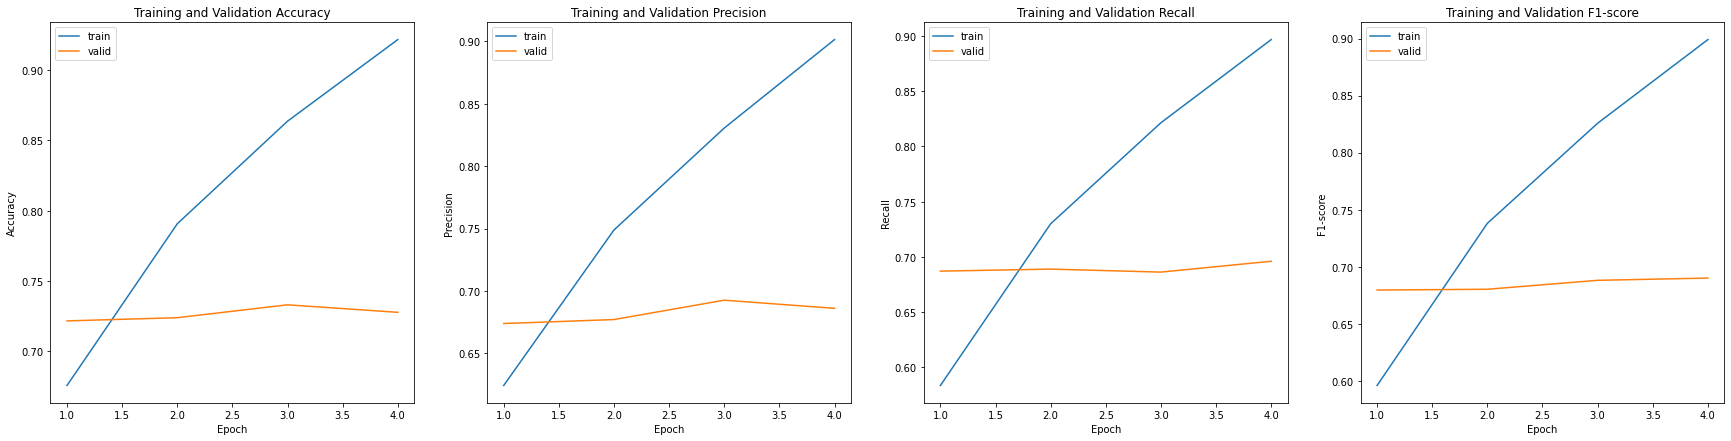

In [56]:
# show line chart
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, figsize=(30, 7))
epoch = [1,2,3,4]

plt1.plot(epoch, train_acc_lists, label='train')
plt1.plot(epoch, eval_acc_lists, label='valid')
plt1.set_title('Training and Validation Accuracy')
plt1.legend()
plt1.set(xlabel='Epoch', ylabel='Accuracy')

plt2.plot(epoch, train_pre_lists, label='train')
plt2.plot(epoch, eval_pre_lists, label='valid')
plt2.set_title('Training and Validation Precision')
plt2.legend()
plt2.set(xlabel='Epoch', ylabel='Precision')

plt3.plot(epoch, train_rec_lists, label='train')
plt3.plot(epoch, eval_rec_lists, label='valid')
plt3.set_title('Training and Validation Recall')
plt3.legend()
plt3.set(xlabel='Epoch', ylabel='Recall')

plt4.plot(epoch, train_f1_lists, label='train')
plt4.plot(epoch, eval_f1_lists, label='valid')
plt4.set_title('Training and Validation F1-score')
plt4.legend()
plt4.set(xlabel='Epoch', ylabel='F1-score')

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

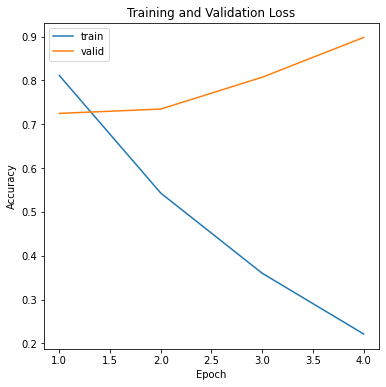

In [57]:
# show line chart
fig, plt1 = plt.subplots(1, 1, figsize=(6, 6))
epoch = [1,2,3,4]

plt1.plot(epoch, train_loss_lists, label='train')
plt1.plot(epoch, eval_loss_lists, label='valid')
plt1.set_title('Training and Validation Loss')
plt1.legend()
plt1.set(xlabel='Epoch', ylabel='Accuracy')

In [58]:
# constructing dataframe from training
df_stats = {'Train Accuracy': np.round(train_acc_lists, 2), 'Train Precision': np.round(train_pre_lists,2), 'Train Recall': np.round(train_rec_lists,2), 'Train F1': np.round(train_f1_lists,2), 'Valid Accuracy': np.round(eval_acc_lists,2), 'Valid Precision': np.round(eval_pre_lists,2), 'Valid Recall': np.round(eval_rec_lists,2), 'Valid F1': np.round(eval_f1_lists,2), 'Train Loss': np.round(train_loss_lists,2), 'Valid Loss': np.round(eval_loss_lists,2)}

# create a dataframe from training
df_stats = pd.DataFrame(data=df_stats)

# rename row index as 'Epoch'
df_stats = df_stats.rename_axis('Epoch')

# display the table
df_stats.index = df_stats.index + 1
df_stats

,Train Accuracy,Train Precision,Train Recall,Train F1,Valid Accuracy,Valid Precision,Valid Recall,Valid F1,Train Loss,Valid Loss
Epoch,,,,,,,,,,
1,0.68,0.62,0.58,0.60,0.72,0.67,0.69,0.68,0.81,0.72
2,0.79,0.75,0.73,0.74,0.72,0.68,0.69,0.68,0.54,0.73
3,0.86,0.83,0.82,0.83,0.73,0.69,0.69,0.69,0.36,0.81
4,0.92,0.90,0.90,0.90,0.73,0.69,0.70,0.69,0.22,0.90


In [59]:
# evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(testing_loader, leave=True, total=len(testing_loader))
for i, batch_data in enumerate(pbar):
  _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=device)
  list_hyp += batch_hyp

100%|██████████| 41/41 [00:03<00:00, 12.23it/s]


## 3.5 Save Prediction

In [60]:
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('prediction.txt', index=False)

print(df)

      index        label
0         0       Non_HS
1         1       Non_HS
2         2      HS_Weak
3         3       Non_HS
4         4  HS_Moderate
...     ...          ...
1307   1307    HS_Strong
1308   1308  HS_Moderate
1309   1309       Non_HS
1310   1310       Non_HS
1311   1311       Non_HS

[1312 rows x 2 columns]


## 3.6 Evaluation with Confusion Matrix

In [61]:
prediction = pd.read_csv('prediction.txt')

In [62]:
prediction_list = []

for i in prediction['label'] : 
  if i == 'HS_Weak': 
    prediction_list.append(1)
  elif i == 'HS_Moderate': 
    prediction_list.append(2)
  elif i == 'HS_Strong': 
    prediction_list.append(3)
  else :
    prediction_list.append(0)

In [63]:
data_test = pd.read_csv('dataset_testing.csv')

def label_classification(hs):
  label = ''
  
  if str(hs) == 'HS_Weak':
    label = 1
  elif str(hs) == 'HS_Moderate':
    label = 2
  elif str(hs) == 'HS_Strong':
    label = 3
  else:
    label = 0

  return label

data_test['label'] = data_test['label'].apply(label_classification)

data_test = data_test[['text', 'label']]

data_test.head()

,text,label
0,adik tengok keliling adik nak cam agama first ...,0
1,malas duduk xleh orang kg budaya kg duduk xleh...,0
2,res res cebong goblok ya res maklum,2
3,tahu gue sih indonesia barat gue orang aku ate...,0
4,sadar bahasa kampret cebong sekian tebar bahas...,2


In [64]:
print(f"Accuracy: {round(accuracy_score(data_test['label'], prediction_list), 2)}") 
print(f"Precision: {round(precision_score(data_test['label'], prediction_list, average='macro'), 2)}")
print(f"Recall: {round(recall_score(data_test['label'], prediction_list, average='macro'), 2)}")

Accuracy: 0.74
Precision: 0.7
Recall: 0.7


In [65]:
# micro avg of f1-score
f1_score_micro = f1_score(data_test['label'], prediction_list, average='micro') * 100
print("F1-score (Micro Avg) is {}%." .format(round(f1_score_micro),1))

# macro avg of f1-score
f1_score_macro = f1_score(data_test['label'], prediction_list, average='macro') * 100
print("F1-score (Macro Avg) is {}%." .format(round(f1_score_macro),1))

# weighted avg of f1-score
f1_score_weighted = f1_score(data_test['label'], prediction_list, average='weighted') * 100
print("F1-score (Weighted Avg) is {}%." .format(round(f1_score_weighted),1))

F1-score (Micro Avg) is 74%.
F1-score (Macro Avg) is 70%.
F1-score (Weighted Avg) is 74%.


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       577
           1       0.66      0.63      0.64       332
           2       0.57      0.62      0.59       173
           3       0.71      0.69      0.70       230

    accuracy                           0.74      1312
   macro avg       0.70      0.70      0.70      1312
weighted avg       0.74      0.74      0.74      1312


Confusion Matrix:


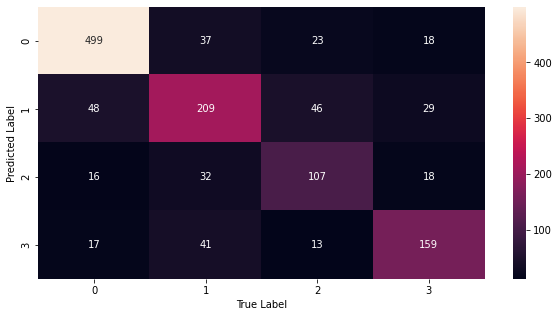

In [66]:
print("Classification Report:")
print(classification_report(data_test['label'], prediction_list))

print("\nConfusion Matrix:")
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(data_test['label'], prediction_list), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

## 3.7 Test Fine-Tuned Model

In [67]:
text = 'kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kebahagiaan terbesarku adalah melihatmu bersama dengan dirinya
Label: Non_HS (98.632%)


In [68]:
text = 'beban keluarga ga jelas emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: beban keluarga ga jelas emang
Label: Non_HS (53.731%)


In [69]:
text = 'antek antek komunis mati sana'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: antek antek komunis mati sana
Label: HS_Moderate (89.640%)


In [70]:
text = 'kemaren gue ga di ajak tai emang'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text}')
print(f'Label: {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: kemaren gue ga di ajak tai emang
Label: HS_Strong (62.032%)


In [71]:
print(logits)

tensor([[ 0.1160,  0.1904, -1.3308,  1.4453]], device='cuda:0')


In [72]:
print(torch.topk(logits, 1))

torch.return_types.topk(
values=tensor([[1.4453]], device='cuda:0'),
indices=tensor([[3]], device='cuda:0'))


# **Save Model**

In [73]:
# output_dir = '/content/drive/MyDrive/Data/hate-speech-detection/model_save/'

# # create output directory
# if not os.path.exists(output_dir):
#   os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # save a trained model, configuration and tokenizer using 'save_pretrained()'.
# model_to_save = model.module if hasattr(model, 'module') else model
# model_to_save.save_pretrained(output_dir)

# tokenizer.save_pretrained(output_dir)

In [74]:
# # save
# with open('/content/drive/MyDrive/Data/hate-speech-detection/model_save/tokenizer.pkl', 'wb') as handle:
#   pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
# !ls -l --block-size=K /content/drive/MyDrive/Data/hate-speech-detection/model_save/

In [76]:
# amount_of_true_non_hs = 0
# amount_of_true_hs = 0

# for i in data_test['label'] :
#   if i == 'Non_HS' :
#     amount_of_true_non_hs += 1
#   else :
#     amount_of_true_hs += 1

# print(amount_of_true_non_hs)
# print(amount_of_true_hs)

In [77]:
# amount_of_pred_non_hs = 0
# amount_of_pred_hs = 0

# for i in prediction_list :
#   if i == 'Non_HS' :
#     amount_of_pred_non_hs += 1
#   else :
#     amount_of_pred_hs += 1

# print(amount_of_pred_non_hs)
# print(amount_of_pred_hs)

In [78]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# # true result
# labels = 'Non_HS', 'HS'
# sizes = [amount_of_true_non_hs, amount_of_true_hs]
# explode = (0.1, 0)

# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# ax1.axis('equal')
# ax1.set_title('Labeling True Result')

# # prediction result
# labels = 'Non_HS', 'HS'
# sizes = [amount_of_pred_non_hs, amount_of_pred_hs]
# explode = (0.1, 0)

# ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# ax2.axis('equal')
# ax2.set_title('Labeling Prediction Result')

# ax1.plot()
# ax2.plot()